# Tensorflow - A Quick Guide

In this notebook I would like to provide a quick guide through Tensorflow by implementing an LSTM-type auto-encoder. This script should be directly runnable, so feel free to adjust any parameters or try any other implementations.

## Environment

Python: 2.7.6

Tensorflow: 0.9r

Required Python packages: numpy, h5py, scikits.audiolab



Warning: please make sure to ```import numpy``` before you ```import tensorflow```, otherwise Python will crash!

In [1]:
# import necessary packages

import numpy as np
import tensorflow as tf
import datetime
import time
import h5py
from scikits.audiolab import wavread, wavwrite
import logging
import matplotlib.pyplot as plt
import threading

%matplotlib inline

/home/yluo/.local/lib/python2.7/site-packages/scikits/audiolab/soundio/play.py:48: UserWarning: Could not import alsa backend; most probably, you did not have alsa headers when building audiolab
  warnings.warn("Could not import alsa backend; most probably, "


In [2]:
# set up the logger
# simply copy these codes to any other scripts

logger = logging.getLogger('')
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

First, set up the data directory. I've put the example data in the same directory as this script. I've chosen `h5py` to save the data (since I'll also show how to load data asynchronously), but you can also use `numpy.save` or anything else for your data.

In [3]:
data_loading = h5py.File('example_data.hdf5')
X = data_loading['input']
X /= np.max(np.abs(X))

This (very) small dataset contains 1000 clips of speech, each with length of 100 frames.

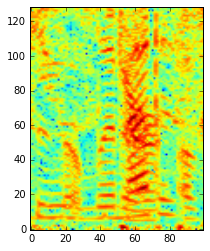

In [4]:
plt.imshow(X[0].T, origin='lower')
plt.show()

And we set some parameters that will be used. Since here we only have few data, we set the number of hidden units in LSTM to be small.

In [5]:
# param

chunk_size = 100 # time step length
infeat_dim = 129 # input dimension
batch_size = 200 # batch size
learning_rate = 1e-3 # learning rate
nepoch = 100 # number of epoches during training
lstm_hidden = 50 # number of hidden units in a LSTM cell

Our task is to implement an auto-encoder. We first take a look at the basic data structures in Tensorflow.  

Since Tensorflow is also using a graph-based framework, the basic usage is very similar to Theano. If you are already familiar with Theano, it will be very easy for you to start working on Tensorflow. You can directly go to the codes.

In Tensorflow, all the information are transferred by `Tensors`, and all the `Tensors` are contained in a `graph`. Our task is to construct the nodes and calculations in the graph, and Tensorflow will arange and execute them for us. To create an instance of a node in the graph, typically we use `tf.placeholder` (which is similar to `theano.tensor.tensor`). For example, here we create a note for the input of out network, which has shape `(batch_size, time_step, input_dimension)`

In [6]:
input = tf.placeholder(tf.float32, shape=[batch_size, chunk_size, infeat_dim])

In the current version of Tensorflow, I think the support for variable batch size is pretty poor - I'll talk about it later.

Then we build a one-layer LSTM network. Notice that the input to LSTM network in Tensorflow should be a list of length `time_step`, while the shape of each time step should be `(batch_size, input_dimension)`, so here we need to reshape our input.

In [7]:
# reshape the input

# tf.pack function will merge a list of tensors into one tensor, 
# while tf.unpack function will split a tensor into a list of tensors (according to one dimension)

# tf.transpose function is the same as numpy.transpose, which can shuffle the dimensions of a tensor

lstm_input = tf.unpack(tf.transpose(input, [1,0,2])) # now input is a list of tensors

# LSTM cell
cell = tf.nn.rnn_cell.LSTMCell(lstm_hidden, use_peepholes=True, state_is_tuple=True)

# initial states
initial_state = cell.zero_state(batch_size, tf.float32)

output, _ = tf.nn.rnn(cell, lstm_input, initial_state=initial_state)

# the output has the same shape as the input (so it's also a list), and we want to pack it into one tensor
# and reshape it into shape (batch_size, time_step, output_dimension)

output = tf.transpose(tf.pack(output), [1,0,2])

And we add an feedforward layer for output. In a feedforward layer, we need a weight matri `W` and a bias vector `b`. Here, we can use `tf.Variable` to create them. The advantage of `tf.Variable` is that we could feed the initial value into it, but if we want to assign value to it later, we need to use `tf.assign(param, value)`.

In [8]:
# output layer

# weight matrix with truncated_normal initializer
W = tf.Variable(tf.random_normal([lstm_hidden, infeat_dim], stddev=.01))

# bias vector initialized with zero
b = tf.Variable(tf.constant(0., shape=[infeat_dim]))


# need to reshape the input tensor into a 2-dimension tensor

# a trick: to get the dimension of a tensor as an integer, you can try as below
# get_shape().as_list() will return the shape of a tensor a list of integers

output = tf.reshape(output, [-1, output.get_shape().as_list()[-1]])

# matrix multiplication
output = tf.matmul(output, W) + b  # shape: (batch_size*time_step, input_dimension)

# nonlinearity
# here we use tanh, you can also use tf.nn.softmax, tf.nn.relu, tf.nn.sigmoid, etc.

output = tf.nn.tanh(output)  # shape: (batch_size*time_step, input_dimension)

output = tf.reshape(output, [-1, chunk_size, infeat_dim])  # shape: (batch_size, time_step, input_dimension)

And now we can design the objective function and the optimizer. 

For the objective function, here we simply use the L2-loss.

For the optimizer, we use RMSProp algorithm for updating the parameters. The way to define an optimizer is as follows:

In [9]:
# objective function

loss = tf.reduce_mean(tf.nn.l2_loss(output-input))

# optimizer

learning_rate = 1e-3
lr = tf.Variable(learning_rate, name='learning_rate', trainable=False)
train_op = tf.train.RMSPropOptimizer(lr).minimize(loss) # this is the operator for updating all the params

You may also use other ways to define an optimizer, possibly with other tricks such as gradient clipping and gradient normalization. If you want to do that, you can do things like this:

```Python
optimizer = tf.train.RMSPropOptimizer(learning_rate)
gvs = optimizer.compute_gradients(loss)
# do the gradient clipping
capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gvs]
train_op = optimizer.apply_gradients(capped_gvs)
```

But here we only use the first and simpler one.

Now, our one-layer LSTM-type auto-encoder is here, and we want to test if it works.

Tensorflow uses a `session` to run a graph (or part of a graph). All operations need a session to run. To create a session, use `tf.Session()`.

One thing I want to mention is that Tensorflow tends to use all possible GPUs in default, and pre-occupy all the available memories of one specific GPU (if you specify it). This is really stupid. Since we may need to share one GPU with several people, I suggest that we create a session like this:

```Python
%env CUDA_VISIBLE_DEVICES=1 # only make one device visible, so Tensorflow will not use any of the other GPUs

with tf.device('/gpu:0'):
    config = tf.ConfigProto() # create a configuration
    
    config.gpu_options.allow_growth = True # this will make Tensorflow to soft allocate the memories, 
                                           # so that it will not pre-allocate all the memories in a GPU.
                                           # Instead it will gradually increase the memory usage
    
    config.gpu_options.per_process_gpu_memory_fraction = 0.4 # this is the maximum fraction of memory that 
                                                             # could be used in a GPU. I suggest to set it lower
                                                             # than 0.5, so that one GPU could be shared 
                                                             # by two people
    
    session = tf.Session(config=config) # start a session
```

Or you can simply use cpu:

```Python
%env CUDA_VISIBLE_DEVICES='' # do not use any GPUs

with tf.device('/cpu'):
    session = tf.Session() # start a session
```

Here we use CPU only. 

Now we train the model. Here we want to use our dataset as the input to the network, i.e. to fill the `input` Tensor with our data. This could be done by passing the `feed_dict` param to `session.run`.

In [10]:
%env CUDA_VISIBLE_DEVICES=''
with tf.device('/cpu'):
    session = tf.Session()
    
    # make sure to initialize all the params!
    
    init = tf.initialize_all_variables()
    session.run(init)
    logger.info('Network initialized.')
    
    # training
    logger.info('Start training...\n')
    for i in range(nepoch):
        start_time = time.time()
        
        # each batch
        num_batch = X.shape[0] // batch_size
        cost_value = 0.
        for batch in range(num_batch):
            # training
            current_input = np.asarray(X[batch*batch_size:(batch+1)*batch_size,:,:])
            session.run(train_op, feed_dict={input:current_input})
            # get the cost value
            cost_value += session.run(loss, feed_dict={input:current_input}) / num_batch
            
        logger.info('Epoch {}, Loss : {}, time spent: {}'.format(i+1, cost_value/batch_size, time.time()-start_time))
    
    logger.info('\nTraining finished.')

env: CUDA_VISIBLE_DEVICES=''


Network initialized.
Start training...

Epoch 1, Loss : 198.435097656, time spent: 1.93266296387
Epoch 2, Loss : 158.722697266, time spent: 1.26816010475
Epoch 3, Loss : 140.316955078, time spent: 1.26803779602
Epoch 4, Loss : 128.919269531, time spent: 1.26152992249
Epoch 5, Loss : 121.125666016, time spent: 1.25808191299
Epoch 6, Loss : 115.120759766, time spent: 1.2550368309
Epoch 7, Loss : 110.275703125, time spent: 1.25541591644
Epoch 8, Loss : 106.105441406, time spent: 1.26083707809
Epoch 9, Loss : 102.546839844, time spent: 1.25744199753
Epoch 10, Loss : 99.4259199219, time spent: 1.25703406334
Epoch 11, Loss : 96.8792480469, time spent: 1.25969696045
Epoch 12, Loss : 94.2134375, time spent: 1.25732398033
Epoch 13, Loss : 91.8091269531, time spent: 1.26660704613
Epoch 14, Loss : 89.68025, time spent: 1.25980114937
Epoch 15, Loss : 87.6707910156, time spent: 1.25209116936
Epoch 16, Loss : 85.52853125, time spent: 1.25356221199
Epoch 17, Loss : 83.7339628906, time spent: 1.256931

Notice that here I haven't shuffled the training data in each epoch. 

Let's take a look at the output.

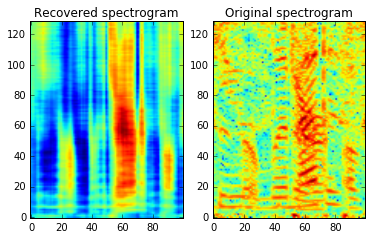

In [11]:
# get the output of the network of a partiular input

test_input = np.asarray(X[:batch_size,:,:])
recover_spec = session.run(output, feed_dict={input:test_input})
# reshape the output
recover_spec = recover_spec.reshape((batch_size, chunk_size, -1))
# plot them

plt.subplot(121)
plt.imshow(recover_spec[0].T, origin='lower')
plt.title('Recovered spectrogram')
plt.subplot(122)
plt.imshow(test_input[0].T, origin='lower')
plt.title('Original spectrogram')
plt.show()

What we can do next is to try a deep LSTM model. Below is a simple function to stack multiple LSTMs. Tensorflow provides a function `tf.nn.rnn_cell.MultiRNNCell` to stack multiple RNNCells, so it will be very easy to build such a network.

In [11]:
def Multi_LSTM(X, num_layer, n_hidden, name='LSTM'):
    assert type(n_hidden) in [int, list]
    if type(n_hidden) is int:
        n_hidden = np.ones(num_layer, dtype=np.int64) * n_hidden
        
    assert len(n_hidden) == num_layer
    
    batch_size = X[0].get_shape().as_list()[0]
    
    lstm = []
    for n in range(num_layer):
        lstm.append(tf.nn.rnn_cell.LSTMCell(n_hidden[n], use_peepholes=True, state_is_tuple=True))
    
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(lstm,state_is_tuple=True)
    
    initial_state = stacked_lstm.zero_state(batch_size, tf.float32)
    
    output, states, = tf.nn.rnn(stacked_lstm, X, initial_state=initial_state)

    return tf.transpose(tf.pack(output), [1,0,2])

In [12]:
# 2-layer LSTM auto-encoder

new_input = tf.placeholder(tf.float32, shape=[batch_size, chunk_size, infeat_dim])
new_lstm_input = tf.unpack(tf.transpose(new_input, [1,0,2]))

output = Multi_LSTM(new_lstm_input, 2, lstm_hidden)

# feedforward layer
W_new = tf.Variable(tf.random_normal([output.get_shape().as_list()[-1], infeat_dim], stddev=.01))
b_new = tf.Variable(tf.constant(0., shape=[infeat_dim]))

output = tf.reshape(output, [-1, output.get_shape().as_list()[-1]])
output = tf.matmul(output, W_new) + b_new 

output = tf.nn.tanh(output)

output = tf.reshape(output, [-1, chunk_size, infeat_dim])

# objective function

new_loss = tf.reduce_mean(tf.nn.l2_loss(output-new_input))

# optimizer

learning_rate = 1e-3
lr = tf.Variable(learning_rate, name='learning_rate', trainable=False)
train_op = tf.train.RMSPropOptimizer(lr).minimize(new_loss) # this is the operator for updating all the params

In [13]:
# training
%env CUDA_VISIBLE_DEVICES=''
with tf.device('/cpu'):
    session = tf.Session()
    
    init = tf.initialize_all_variables()
    session.run(init)
    logger.info('Network initialized.')
    
    # training
    logger.info('Start training...\n')
    for i in range(nepoch):
        start_time = time.time()
        
        # each batch
        num_batch = X.shape[0] // batch_size
        cost_value = 0.
        for batch in range(num_batch):
            # training
            current_input = np.asarray(X[batch*batch_size:(batch+1)*batch_size,:,:])
            session.run(train_op, feed_dict={new_input:current_input})
            # get the cost value
            cost_value += session.run(new_loss, feed_dict={new_input:current_input}) / num_batch
            
        logger.info('Epoch {}, Loss : {}, time spent: {}'.format(i+1, cost_value/batch_size, time.time()-start_time))
    
    logger.info('\nTraining finished.')

env: CUDA_VISIBLE_DEVICES=''


Network initialized.
Start training...

Epoch 1, Loss : 217.256421875, time spent: 3.0365319252
Epoch 2, Loss : 187.095074219, time spent: 1.544932127
Epoch 3, Loss : 167.505572266, time spent: 1.54735517502
Epoch 4, Loss : 153.716820312, time spent: 1.54402804375
Epoch 5, Loss : 145.570177734, time spent: 1.53784584999
Epoch 6, Loss : 137.539746094, time spent: 1.54315090179
Epoch 7, Loss : 131.009730469, time spent: 1.53596878052
Epoch 8, Loss : 127.098660156, time spent: 1.53776097298
Epoch 9, Loss : 125.012263672, time spent: 1.536673069
Epoch 10, Loss : 118.737197266, time spent: 1.53869080544
Epoch 11, Loss : 117.949013672, time spent: 1.53828907013
Epoch 12, Loss : 114.991152344, time spent: 1.53389215469
Epoch 13, Loss : 113.189396484, time spent: 1.54193997383
Epoch 14, Loss : 111.161308594, time spent: 1.54007101059
Epoch 15, Loss : 108.904414062, time spent: 1.537774086
Epoch 16, Loss : 108.479039062, time spent: 1.53703403473
Epoch 17, Loss : 106.296412109, time spent: 1.54

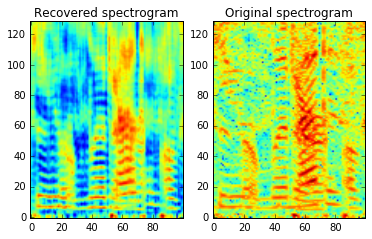

In [14]:
test_input = np.asarray(X[:batch_size,:,:])
recover_spec = session.run(output, feed_dict={new_input:test_input})
# reshape the output
recover_spec = recover_spec.reshape((batch_size, chunk_size, -1))
# plot them

plt.subplot(121)
plt.imshow(recover_spec[0].T, origin='lower')
plt.title('Recovered spectrogram')
plt.subplot(122)
plt.imshow(test_input[0].T, origin='lower')
plt.title('Original spectrogram')
plt.show()

Also we can build a deep BLSTM model using `tf.nn.rnn_cell.MultiRNNCell`.

In [6]:
def Multi_BLSTM(X, num_layer, n_hidden, name='BLSTM'):
    assert type(n_hidden) in [int, list]
    if type(n_hidden) is int:
        n_hidden = np.ones(num_layer, dtype=np.int64) * n_hidden
        
    assert len(n_hidden) == num_layer
    
    batch_size = X[0].get_shape().as_list()[0]
    
    with tf.variable_scope(name):
        # forward cells
        lstm_fw = []
        # backward cells
        lstm_bw = []

        for n in range(num_layer):
            lstm_fw.append(tf.nn.rnn_cell.LSTMCell(lstm_hidden, use_peepholes=True, state_is_tuple=True))
            lstm_bw.append(tf.nn.rnn_cell.LSTMCell(lstm_hidden, use_peepholes=True, state_is_tuple=True))

        stacked_lstm_fw = tf.nn.rnn_cell.MultiRNNCell(lstm_fw,state_is_tuple=True)
        stacked_lstm_bw = tf.nn.rnn_cell.MultiRNNCell(lstm_bw,state_is_tuple=True)

        _initial_state_fw = stacked_lstm_fw.zero_state(batch_size, tf.float32)
        _initial_state_bw = stacked_lstm_bw.zero_state(batch_size, tf.float32)

        output, _states_fw, _states_bw = tf.nn.bidirectional_rnn(stacked_lstm_fw, stacked_lstm_bw, X, 
                                                  initial_state_fw=_initial_state_fw,
                                                  initial_state_bw=_initial_state_bw)

    return tf.transpose(tf.pack(output), [1,0,2])

In [17]:
# 2-layer BLSTM auto-encoder

next_input = tf.placeholder(tf.float32, shape=[batch_size, chunk_size, infeat_dim])
blstm_input = tf.unpack(tf.transpose(next_input, [1,0,2]))

output = Multi_BLSTM(blstm_input, 2, lstm_hidden, name='BLSTM1')

# feedforward layer
W_blstm = tf.Variable(tf.random_normal([output.get_shape().as_list()[-1], infeat_dim], stddev=.01))
b_blstm = tf.Variable(tf.constant(0., shape=[infeat_dim]))

output = tf.reshape(output, [-1, output.get_shape().as_list()[-1]])
output = tf.matmul(output, W_blstm) + b_blstm 

output = tf.nn.tanh(output)

output = tf.reshape(output, [-1, chunk_size, infeat_dim])

# objective function

new_loss = tf.reduce_mean(tf.nn.l2_loss(output-next_input))

# optimizer

learning_rate = 1e-3
lr = tf.Variable(learning_rate, name='learning_rate', trainable=False)
train_op = tf.train.RMSPropOptimizer(lr).minimize(new_loss)

# training
%env CUDA_VISIBLE_DEVICES=''
with tf.device('/cpu'):
    session = tf.Session()
    
    init = tf.initialize_all_variables()
    session.run(init)
    logger.info('Network initialized.')
    
    # training
    logger.info('Start training...\n')
    for i in range(nepoch):
        start_time = time.time()
        
        # each batch
        num_batch = X.shape[0] // batch_size
        cost_value = 0.
        for batch in range(num_batch):
            # training
            current_input = np.asarray(X[batch*batch_size:(batch+1)*batch_size,:,:])
            session.run(train_op, feed_dict={next_input:current_input})
            # get the cost value
            cost_value += session.run(new_loss, feed_dict={next_input:current_input}) / num_batch
            
        logger.info('Epoch {}, Loss : {}, time spent: {}'.format(i+1, cost_value/batch_size, time.time()-start_time))
    
    logger.info('\nTraining finished.')

env: CUDA_VISIBLE_DEVICES=''


Network initialized.
Start training...

Epoch 1, Loss : 202.093417969, time spent: 6.52630496025
Epoch 2, Loss : 163.256222656, time spent: 2.86009716988
Epoch 3, Loss : 143.674900391, time spent: 2.91879582405
Epoch 4, Loss : 136.747960938, time spent: 2.88040709496
Epoch 5, Loss : 128.966380859, time spent: 2.91666102409
Epoch 6, Loss : 122.331919922, time spent: 2.89037084579
Epoch 7, Loss : 119.637271484, time spent: 2.88642096519
Epoch 8, Loss : 115.807236328, time spent: 2.89937400818
Epoch 9, Loss : 114.047169922, time spent: 2.88485002518
Epoch 10, Loss : 108.794378906, time spent: 2.91744208336
Epoch 11, Loss : 107.694888672, time spent: 2.89053297043
Epoch 12, Loss : 105.462951172, time spent: 2.92215204239
Epoch 13, Loss : 103.816513672, time spent: 2.88230514526
Epoch 14, Loss : 100.652757812, time spent: 2.91640305519
Epoch 15, Loss : 101.092541016, time spent: 2.91327500343
Epoch 16, Loss : 97.166046875, time spent: 2.9277381897
Epoch 17, Loss : 96.4134882812, time spent:

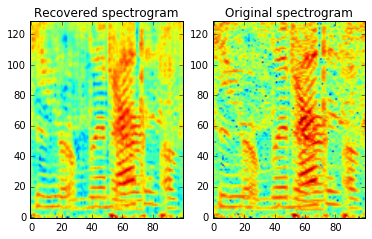

In [18]:
test_input = np.asarray(X[:batch_size,:,:])
recover_spec = session.run(output, feed_dict={next_input:test_input})
# reshape the output
recover_spec = recover_spec.reshape((batch_size, chunk_size, -1))
# plot them

plt.subplot(121)
plt.imshow(recover_spec[0].T, origin='lower')
plt.title('Recovered spectrogram')
plt.subplot(122)
plt.imshow(test_input[0].T, origin='lower')
plt.title('Original spectrogram')
plt.show()

Next task is to implement an asynchronous data loading pipeline to hide the I/O, hence accelerate the training process. This can be done by using `Queue` in Tensorflow.

There are two types of `Queue` in Tensorflow: `tf.RandomShuffleQueue` and `tf.FIFOQueue`. Since typically we need to shuffle the training data, here we use `tf.RandomShuffleQueue`.

In [7]:
# use Queue to fetch data in parallel
# First, define place holders that would be used in the Queue

X_enqueue = tf.placeholder(tf.float32, shape=[chunk_size, X.shape[-1]])

# start a queue

q = tf.RandomShuffleQueue(X.shape[0], batch_size, tf.float32,
                shapes=[chunk_size, X.shape[-1]])

# the operator for enqueue
enqueue_op = q.enqueue(X_enqueue)

def load_and_enqueue(sess, chunk_size, n_batch, n_chunk, enqueue_op, coord):
    # coord is for stopping the data loading thread
    while not coord.should_stop():
    # load the data
        for i in xrange(n_batch):
            for j in xrange(n_chunk):
                load_X = np.array(X[i, j*chunk_size:(j+1)*chunk_size, :])
                try:
                    sess.run(enqueue_op, feed_dict={X_enqueue: load_X})
                except:
                    return

                
# use dequeue_many to fetch a batch  
# you can also use dequeue to fetch one element
X_batch = q.dequeue_many(batch_size)

asyn_input = tf.unpack(tf.transpose(X_batch, [1,0,2]))

# use X_batch as the input to the network

output = Multi_BLSTM(asyn_input, 2, lstm_hidden, name='BLSTM2')

# feedforward layer
W_asyn = tf.Variable(tf.random_normal([output.get_shape().as_list()[-1], infeat_dim], stddev=.01))
b_asyn = tf.Variable(tf.constant(0., shape=[infeat_dim]))

output = tf.reshape(output, [-1, output.get_shape().as_list()[-1]])
output = tf.matmul(output, W_asyn) + b_asyn 

output = tf.nn.tanh(output)

output = tf.reshape(output, [-1, chunk_size, infeat_dim])

# objective function

asyn_loss = tf.reduce_mean(tf.nn.l2_loss(output-X_batch))

# optimizer

learning_rate = 1e-3
lr = tf.Variable(learning_rate, name='learning_rate', trainable=False)
train_op = tf.train.RMSPropOptimizer(lr).minimize(asyn_loss)

In [8]:
# training
%env CUDA_VISIBLE_DEVICES=''
with tf.device('/cpu'):
    session = tf.Session()

    # initialize
    session.run(tf.initialize_all_variables())
    logger.info('Network initialized.')

    # load the data asynchronously
    coord = tf.train.Coordinator()
    # start another thread for data loading
    t = threading.Thread(target=load_and_enqueue, args=(session, chunk_size, X.shape[0], 
                                                        1, enqueue_op, coord))
    t.start()
    logger.info('Data loading started. Start training...\n')

    for i in range(nepoch):
        start_time = time.time()
        
        # each batch
        num_batch = X.shape[0] // batch_size
        cost_value = 0.
        for batch in range(num_batch):
        
            _, cost = session.run([train_op, asyn_loss])  # no need to use feed_dict here
            cost_value += cost / num_batch
        
        logger.info('Epoch {}, Loss : {}, time spent: {}'.format(i+1, cost_value/batch_size, time.time()-start_time))
    
    logger.info('\nTraining finished.')

# close data loading
session.run(q.close(cancel_pending_enqueues=True))
coord.request_stop()
coord.join([t])
logger.info('Data loading closed.')

env: CUDA_VISIBLE_DEVICES=''


Network initialized.
Data loading started. Start training...

Epoch 1, Loss : 212.561972656, time spent: 4.72513699532
Epoch 2, Loss : 162.579724609, time spent: 1.98277688026
Epoch 3, Loss : 139.999560547, time spent: 1.98498392105
Epoch 4, Loss : 132.335298828, time spent: 1.97772884369
Epoch 5, Loss : 124.379597656, time spent: 1.97476005554
Epoch 6, Loss : 119.495488281, time spent: 1.97093296051
Epoch 7, Loss : 116.022984375, time spent: 1.95953583717
Epoch 8, Loss : 110.692796875, time spent: 1.94322705269
Epoch 9, Loss : 107.489587891, time spent: 1.97792291641
Epoch 10, Loss : 105.913017578, time spent: 1.96816706657
Epoch 11, Loss : 102.980234375, time spent: 1.97579288483
Epoch 12, Loss : 100.303210938, time spent: 1.95716190338
Epoch 13, Loss : 97.7872851562, time spent: 1.96142292023
Epoch 14, Loss : 97.286640625, time spent: 1.94786787033
Epoch 15, Loss : 94.002875, time spent: 1.95037198067
Epoch 16, Loss : 92.4239492188, time spent: 1.96106004715
Epoch 17, Loss : 91.2267

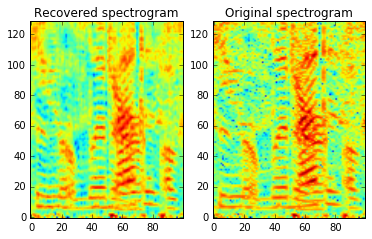

In [9]:
test_input = np.asarray(X[:batch_size,:,:])
# For testing, need to use feed_dict
recover_spec = session.run(output, feed_dict={X_batch:test_input})
# reshape the output
recover_spec = recover_spec.reshape((batch_size, chunk_size, -1))
# plot them

plt.subplot(121)
plt.imshow(recover_spec[0].T, origin='lower')
plt.title('Recovered spectrogram')
plt.subplot(122)
plt.imshow(test_input[0].T, origin='lower')
plt.title('Original spectrogram')
plt.show()